In [2]:
# __future__ import first
from __future__ import annotations


from collections import defaultdict


import torch
import numpy as np
import torch.nn as nn
from torch.distributions.categorical import Categorical
import os

# Gymnasium & Minigrid 
import gymnasium as gym  # Correct way to import Gymnasium
from gymnasium.spaces import Dict, Discrete, Box
from minigrid.core.constants import COLOR_NAMES
from minigrid.core.constants import DIR_TO_VEC
from minigrid.core.grid import Grid
from minigrid.core.actions import Actions
from minigrid.core.mission import MissionSpace
from minigrid.core.world_object import Door, Goal, Key, Wall
from minigrid.manual_control import ManualControl
from minigrid.minigrid_env import MiniGridEnv
from gymnasium.utils.play import play
import pandas as pd
import copy
# Visualization 
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from moviepy import VideoFileClip, TextClip, CompositeVideoClip
from moviepy import ImageSequenceClip
import glob


In [3]:

class SimpleEnv(MiniGridEnv):
    def __init__(
            self, 
            size=10, 
            agent_start_pos=(1, 8), 
            agent_start_dir=0, 
            max_steps=256, 
            **kwargs,
    ):
        self.agent_start_pos = agent_start_pos
        self.agent_start_dir = agent_start_dir
        self.goal_pos = (8, 1)
        
        
        
        mission_space = MissionSpace(mission_func=self._gen_mission)

        super().__init__(
            mission_space=mission_space,
            grid_size=size,
            max_steps=max_steps,
            **kwargs,
        )

        self.action_space = gym.spaces.Discrete(3)
    @staticmethod
    def _gen_mission():
        return "Find the shortest path"

    def _gen_grid(self, width, height):
        #create gird
        self.grid = Grid(width, height)
        #place barrier
        self.grid.wall_rect(0, 0, width, height)
        #place goal
        self.put_obj(Goal(), 8, 1)
        #place walls
        for i in range(1, width // 2):
            self.grid.set(i, width - 4, Wall())
            self.grid.set(i + width // 2 - 1, width - 7, Wall())
        #place agent
        if self.agent_start_pos is not None:
            self.agent_pos = self.agent_start_pos #check this
            self.agent_dir = self.agent_start_dir
        else:
            self.place_agent()

        self.mission = "find the shortest path"
    
    def count_states(self):
        free_cells = sum(1 for x in range(self.grid.width)
                      for y in range(self.grid.height)
                      if not self.grid.get(x, y)) * 4
        return free_cells 


In [4]:
env = SimpleEnv(render_mode='human')
env.reset()

({'image': array([[[1, 0, 0],
          [1, 0, 0],
          [1, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[1, 0, 0],
          [1, 0, 0],
          [1, 0, 0],
          [2, 5, 0],
          [2, 5, 0],
          [2, 5, 0],
          [2, 5, 0]],
  
         [[1, 0, 0],
          [1, 0, 0],
          [1, 0, 0],
          [1, 0, 0],
          [1, 0, 0],
          [1, 0, 0],
          [1, 0, 0]],
  
         [[1, 0, 0],
          [1, 0, 0],
          [1, 0, 0],
          [1, 0, 0],
          [1, 0, 0],
          [1, 0, 0],
          [1, 0, 0]],
  
         [[2, 5, 0],
          [2, 5, 0],
          [2, 5, 0],
          [2, 5, 0],
          [2, 5, 0],
          [2, 5, 0],
          [2, 5, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
 

In [6]:
action = 0
obs, _, _, _, _ = env.step(action)
print("Obs shape after step:", obs["image"].shape)


Obs shape after step: (7, 7, 3)


In [7]:
"""Q learning with no explore/ exploite, Q table is calculated, and a
policy is solved for, with an additional beta term introduced
agent picks sample from the policy distribution"""
class probabilisticQlearning:
    def __init__(
        self,
        env,
        learning_rate = 0.9,
        discount_factor = 0.9,
        #epsilon = 0.5,
        epochs = 200,
        beta = 5
         
    ):
        self.env = env # MiniGrid environment called from the class Minigrid
        self.num_states = ((env.width -2) * (env.height -2) *4)
        self.num_actions = env.action_space.n
        self.Q_table = np.zeros((((env.width -2) * (env.height -2) *4), self.num_actions)) # Q table has goal states in it as well
        # print(f"Q table shape: {self.Q_table.shape}")
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor # discount factor
        # self.epsilon =  epsilon # exploration probability
        self.epochs = epochs
        self.beta = beta


        # information theoretic terms and policy related terms

        self.Pi_a_s = np.full((self.num_states, self.num_actions), 1 / self.num_actions)
        self.Pi_a = np.zeros(self.num_actions)
        self.P_s = np.zeros(self.num_states)
        self.P_s_by_s = np.zeros((self.num_states, self.num_states))
        self.P_s_given_s_a = np.zeros((self.num_states, self.num_actions, self.num_states))
        self.beta = beta
        


        self.allowed_state_idx = self.find_state_indexes(env)
        # print(f"allowed state indexes: {self.allowed_state_idx}")


    
    def position_to_state_index(self, tuple_position = None): 
        grid_width = self.env.grid.width -2
        if tuple_position is None:
            direction = self.env.agent_dir
            x, y = self.env.agent_pos

        else:
            if not isinstance(tuple_position, tuple) or len(tuple_position) != 3:
                raise ValueError(f"Invalid position format: {tuple_position}")
            x, y, direction = tuple_position
        return np.int64(((y-1) * grid_width + (x-1)) * 4 + direction) 
    
    def state_index_to_position(self, state_idx):
        """Converts a scalar state index back into (x, y, direction)."""
        grid_width = self.env.grid.width-2
        
        direction = state_idx % 4
        linear_idx = state_idx // 4

        y, x = divmod(linear_idx, grid_width)  # Convert to (x, y)
        
        return x+1, y+1, direction
    
    def find_state_indexes(self, env):
        """Counts all states except walls and barriers"""
        state_indexes_list = []
        for x in range(1, env.grid.width-1):
            for y in range(1, env.grid.height-1):
                if env.grid.get(x, y) is None: #grabs all empty spaces
                    for direction in range(4):
                        state_index = self.position_to_state_index((x, y, direction))
                        state_indexes_list.append(state_index)
        return state_indexes_list  


    def next_state_index(self, current_state_idx, action):
        # Convert current state index into (x, y, direction)
        x, y, direction = self.state_index_to_position(current_state_idx )
        
        if action == 0:  # Turn left
            direction = (direction - 1) % 4
        elif action == 1:  # Turn right
            direction = (direction + 1) % 4
        elif action == 2:  # Move forward
            if direction == 0:   # looking right increase x
                x += 1
            elif direction == 1: # looking down increase y
                y += 1
            elif direction == 2: # facing left: decrease x
                x -= 1
            elif direction == 3: # looking up: decrease y
                y -= 1
        else:
            raise ValueError(f"Invalid action: {action}")
        
        # Convert the new (x, y, direction) back to a state index.
        next_state = self.position_to_state_index((x, y, direction))
        if next_state not in self.allowed_state_idx:
            # If the next state is not allowed, return the current state
            return current_state_idx
        return next_state
    
    def find_all_next_states(self):
        """Find all possible next states for each state and action."""
        for state in self.allowed_state_idx:
            for action in range(self.num_actions):
                next_state = self.next_state_index(state, action)
                self.P_s_given_s_a[state, action, next_state] = 1
                # print(f"State {state}, Action {action} leads to State {next_state}")

    def find_connected_states(self):
        """
        Build and return a connectivity matrix P_s_by_s where the element at [state, next_state]
        is given by the probability from self.Pi_a_s for the action that leads from state to next_state.
        """
        # Loop over all states.
        for state in self.allowed_state_idx:
            # Loop over all actions for the state.
            for action in range(self.num_actions):
                # Find the next state: assume a deterministic transition where exactly one entry is 1.
                next_state = np.argmax(self.P_s_given_s_a[state, action, :])
                # Set the connectivity matrix: you might choose to sum if multiple actions lead to the same state.
                self.P_s_by_s[state, next_state] = self.Pi_a_s[state, action]
        return self.P_s_by_s

    def calculate_pi(self):
        """Calculate the policy from the Q-table."""
        denominator = np.sum((np.exp(self.beta * self.Q_table)), axis = 1, keepdims=True) # e^(-beta * Q(s,a)) summed over all actions for each state
        numerator = np.exp(self.beta * self.Q_table) # e^(-beta * Q(s,a))
        pi = numerator/denominator
        
        assert np.all(np.isclose(np.sum(pi, axis=1), np.ones(pi.shape[0]), atol=1e-5)), "Policy does not sum to 1 for all states."
        return pi
    
    
    
    def train(self, epochs):
        self.find_all_next_states() #generates self.P(s'|s,a) matrix
        
        goal_states = [self.position_to_state_index((8, 1, d)) for d in range(4)] #goal state index
        
        self.info_to_go_term = []
        self.pi_analysis_term = []

        self.steps = 1

        for epoch in range(epochs):
            
            current_state = np.random.choice(self.allowed_state_idx)
            x,y,dir = self.state_index_to_position(current_state)
            self.env.agent_pos = (x,y)
            self.env.agent_dir = dir
            # print(f"Epoch {epoch}: Starting state: {current_state}")
            # print(f"Epoch {epoch}: Starting position: {self.state_index_to_position(current_state)}")

            epoch_info_to_go = []
            epoch_pi_analysis = []

            while current_state not in goal_states:
                #get the action using pi
                action = np.random.choice(np.arange(self.num_actions), p = self.Pi_a_s[current_state])

                


                #transition to the next state
                next_obs, _, done, _, _ = self.env.step(action)

                # print(f"next_observation: {next_obs}")
                next_state = self.position_to_state_index()
                # print(f"next_state: {next_state}")
                # print(f"next  step: Agent Pos: {self.env.agent_pos}, Dir: {self.env.agent_dir}")
                #reward (-1 for each step thats not the gaol)
                reward = 0 if next_state in goal_states else -1

                self.Q_table[current_state, action] += self.learning_rate * (reward + self.discount_factor * np.max(self.Q_table[next_state]) - self.Q_table[current_state, action])



                #calculate the policy from Q table
                self.Pi_a_s = self.calculate_pi()

                #calculate the P_s (stationary distribution of states)
                initial_s = np.zeros(self.num_states)
                initial_s[current_state] = 1
                self.find_connected_states() #call this to initialize the self.P(s'|s) matrix
                self.Ps_s_matrix = np.linalg.matrix_power(self.P_s_by_s, self.steps)
                self.P_s = np.dot(initial_s .T, self.Ps_s_matrix)   #define P(s)
                assert np.isclose(np.sum(self.P_s), 1), f"Sum of P(s) is not 1: {np.sum(self.P_s)}"
                #calculate the info to go 
                info_to_go = -np.log(self.P_s[next_state] + 1e-15)  # Avoid log(0) by adding a small epsilon
                
                #calculate policy log term
                rows_of_actions_per_state = []
                for s in range(self.num_states):
                    row = self.Pi_a_s[s] * self.P_s[s]
                    # print(f'row in Pi:{self.Pi_a_s[s]} ')
                    # print(f'row {row}')
                    rows_of_actions_per_state.append(row)
                self.Pi_a = np.sum(np.asarray(rows_of_actions_per_state), axis=0)
                
                for a in range(self.num_actions):
                    pi_analysis = (np.log(self.Pi_a_s[next_state, a] + 1e-15) - np.log(self.Pi_a[a]+1e-15))

                #add calculated term into the list:
                epoch_info_to_go.append(info_to_go)
                epoch_pi_analysis.append(pi_analysis)

                #update state
                if next_state in goal_states:
                    break
                # assert(False)
                current_state = next_state
                #recaluclate P_s_by_s because its based off Pi_a_s which is based on Q_table
                self.P_s_by_s = self.find_connected_states()

            self.info_to_go_term.append(epoch_info_to_go)
            self.pi_analysis_term.append(epoch_pi_analysis)

        
        
    
    #changed policy from Q learning term to policy
    def run_policy_2(self):
        """Run the environment using the learned policy from a Q-table."""

        self.env.reset()[0]  # Reset environment
        current_state = self.position_to_state_index()  # Convert starting position to index
        done = False
        step_count = 0  # Track steps to prevent infinite loops



        while not done and step_count < 100:  # Prevent infinite loops
            # Debugging: Print current state and Q-values
            # print(f"Step {step_count}: State {current_state}")
            # print(f"Q-values: {self.Q_table[current_state]}")
            
            action = np.random.choice(np.arange(self.num_actions), p=self.Pi_a_s[current_state])  # Choose best action
            # print(f"Chosen action: {action}")

            # Before taking the step, print agent's current position
            # print(f"Before step: Agent Pos: {self.env.agent_pos}, Dir: {self.env.agent_dir}")

            next_obs, _, done, _, _ = self.env.step(action)  # Take action

            # After step, print agent's new position
            # print(f"After step: Agent Pos: {self.env.agent_pos}, Dir: {self.env.agent_dir}")

            next_state = self.position_to_state_index()  # Convert new state

            # Detect if the agent is looping in the same state
            # if next_state == current_state:
            #     # print(f"⚠️ Warning: Agent is stuck! Current state {current_state} is the same as next state {next_state}.")
            #     break  # Prevent infinite loop

            self.env.render()  # Visualize movement
            # Calculate info to go term for the current step



            current_state = next_state  # Update current state
            step_count += 1



    def run_policy_stats(self):
        """
        Run the environment using the learned policy from a Q-table and collect statistics.
        """
        self.find_all_next_states() #generates P(s'|s,a) matrix
        self.find_connected_states() #call this to initialize the P(s'|s) matrix, no need to recalculate bc Pi stays the same
        


        self.env.reset()[0]  # Reset environment
        current_state = self.position_to_state_index()  # Convert starting position to index
        done = False
        step_count = 0  # Track steps to prevent infinite loops

        self.info_to_go_stats = []
        self.pi_analysis_stats = []

        while not done and step_count < 100:  # Prevent infinite loops
            # Debugging: Print current state and Q-values
            # print(f"Step {step_count}: State {current_state}")
            # print(f"Q-values: {self.Q_table[current_state]}")
            
            action = np.random.choice(np.arange(self.num_actions), p=self.Pi_a_s[current_state])  # Choose best action
            # print(f"Chosen action: {action}")

            # Before taking the step, print agent's current position
            # print(f"Before step: Agent Pos: {self.env.agent_pos}, Dir: {self.env.agent_dir}")

            next_obs, _, done, _, _ = self.env.step(action)  # Take action

            # After step, print agent's new position
            # print(f"After step: Agent Pos: {self.env.agent_pos}, Dir: {self.env.agent_dir}")

            next_state = self.position_to_state_index()  # Convert new state



            self.env.render()  # Visualize movement
            # Calculate info to go term for the current step

        #calculate the P_s (stationary distribution of states)
            initial_s = np.zeros(self.num_states)
            initial_s[current_state] = 1
            self.find_connected_states() #call this to initialize the self.P(s'|s) matrix
            self.Ps_s_matrix = np.linalg.matrix_power(self.P_s_by_s, self.steps)
            self.P_s = np.dot(initial_s .T, self.Ps_s_matrix)   #define P(s)
            assert np.isclose(np.sum(self.P_s), 1), f"Sum of P(s) is not 1: {np.sum(self.P_s)}"
            #calculate the info to go 
            info_to_go = -np.log(self.P_s[next_state] + 1e-15)  # Avoid log(0) by adding a small epsilon
            
            #calculate policy log term
            rows_of_actions_per_state = []
            for s in range(self.num_states):
                row = self.Pi_a_s[s] * self.P_s[s]
                # print(f'row in Pi:{self.Pi_a_s[s]} ')
                # print(f'row {row}')
                rows_of_actions_per_state.append(row)
            self.Pi_a = np.sum(np.asarray(rows_of_actions_per_state), axis=0)
            
            for a in range(self.num_actions):
                pi_analysis = (np.log(self.Pi_a_s[next_state, a] + 1e-15) - np.log(self.Pi_a[a]+1e-15))

            #add calculated term into the list:
            self.info_to_go_stats.append(info_to_go)
            self.pi_analysis_stats.append(pi_analysis)

            



            current_state = next_state  # Update current state
            step_count += 1

        
        



In [8]:
env = SimpleEnv(render_mode=None)
env.reset()

({'image': array([[[1, 0, 0],
          [1, 0, 0],
          [1, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[1, 0, 0],
          [1, 0, 0],
          [1, 0, 0],
          [2, 5, 0],
          [2, 5, 0],
          [2, 5, 0],
          [2, 5, 0]],
  
         [[1, 0, 0],
          [1, 0, 0],
          [1, 0, 0],
          [1, 0, 0],
          [1, 0, 0],
          [1, 0, 0],
          [1, 0, 0]],
  
         [[1, 0, 0],
          [1, 0, 0],
          [1, 0, 0],
          [1, 0, 0],
          [1, 0, 0],
          [1, 0, 0],
          [1, 0, 0]],
  
         [[2, 5, 0],
          [2, 5, 0],
          [2, 5, 0],
          [2, 5, 0],
          [2, 5, 0],
          [2, 5, 0],
          [2, 5, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
 

In [6]:
test = probabilisticQlearning(env)

In [7]:
test.train(epochs=10)  # Train the Q-learning agent for 1000 epochs

In [158]:
env_human = SimpleEnv(render_mode="human") #make same env but in human mode 

test.env= env_human #switch out the env in q training with human env
test.run_policy_2() #run the policy in the human env

In [34]:
test.run_policy_2()

## Plot the Information theory and Policy related term 

In [13]:
#graph the results of the training
# Plotting the info to go term over epochs
plt.figure(figsize=(12, 6))

# Plot info_to_go_term from index 0 to 499
plt.plot(test.info_to_go_term[4])

# Labeling axes and title
plt.xlabel('Epoch')
plt.ylabel('Info to Go Term')
plt.title('Info to Go Term Over Epochs')

# Display the plot
plt.show()



KeyboardInterrupt: 

In [16]:
#graph the results of the training
# Plotting the info to go term over epochs
plt.figure(figsize=(12, 6))

# Plot info_to_go_term from index 0 to 499
plt.plot(test.pi_analysis_term[1])

# Labeling axes and title
plt.xlabel('Steps')
plt.ylabel('Decision Complexity')
plt.title('Pi(a|s) Over Pi(a) per Step')

# Display the plot
plt.show()

KeyboardInterrupt: 

In [40]:
test.pi_analysis_term[0]

[np.float64(2.220446049250313e-16),
 np.float64(0.3972135219168621),
 np.float64(-0.00532949829427376),
 np.float64(2.220446049250313e-16),
 np.float64(-0.21873309406510943),
 np.float64(-4.094626933738931),
 np.float64(0.0105688856258217),
 np.float64(0.6559030830308772),
 np.float64(-0.21873309406510943),
 np.float64(-0.21873309406510943),
 np.float64(-0.21873309406510943),
 np.float64(0.6559030830308772),
 np.float64(2.220446049250313e-16),
 np.float64(0.3972135219168621),
 np.float64(-0.00532949829427376),
 np.float64(2.220446049250313e-16),
 np.float64(-0.21873309406510943),
 np.float64(-0.21873309406510943),
 np.float64(2.220446049250313e-16),
 np.float64(0.17901274720218396),
 np.float64(-0.00532949829427376),
 np.float64(1.0660067756211684),
 np.float64(-0.2835306048415993),
 np.float64(2.220446049250313e-16),
 np.float64(0.17901274720218396),
 np.float64(-0.00532949829427376),
 np.float64(-0.6739917052862713),
 np.float64(0.17901274720218385),
 np.float64(-0.6713534858850783),

## Policy and Info Terms for Trained Model

In [179]:
test.run_policy_stats()

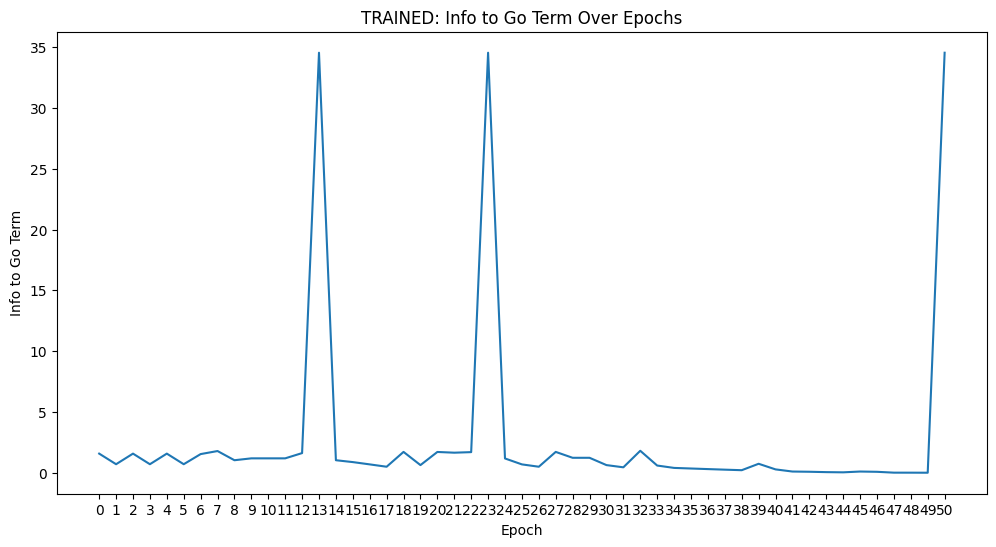

In [180]:
#graph the results of the training
# Plotting the info to go term over epochs
plt.figure(figsize=(12, 6))

# Plot info_to_go_term from index 0 to 499
plt.plot(test.info_to_go_stats)

# Labeling axes and title
plt.xlabel('Epoch')
plt.xticks([i for i in range(0, len(test.info_to_go_stats), 1)])  # Show every 1th epoch for clarity
plt.ylabel('Info to Go Term')
plt.title('TRAINED: Info to Go Term Over Epochs')

# Display the plot
plt.show()

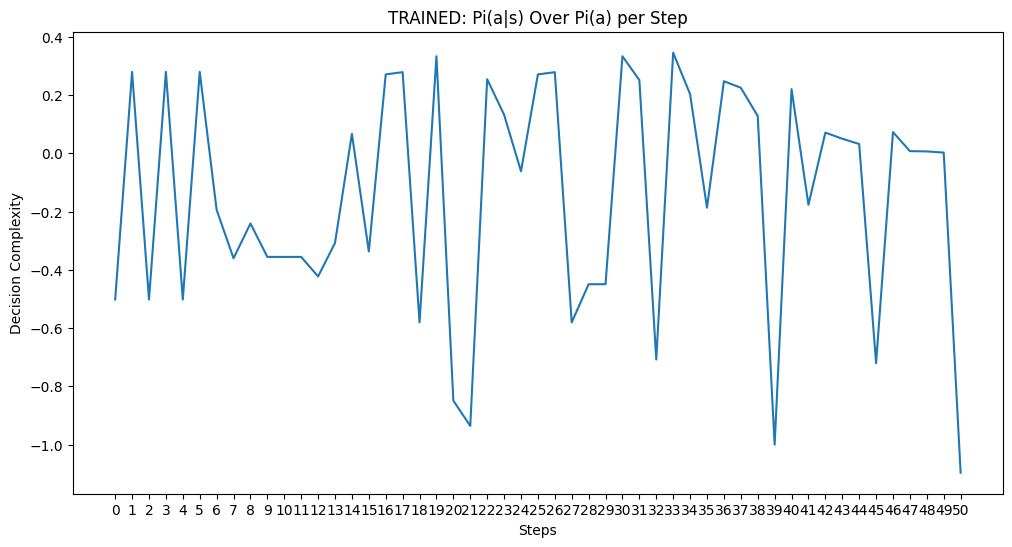

In [181]:
#graph the results of the training
# Plotting the info to go term over epochs
plt.figure(figsize=(12, 6))

# Plot info_to_go_term from index 0 to 499
plt.plot(test.pi_analysis_stats)

# Labeling axes and title
plt.xlabel('Steps')
plt.ylabel('Decision Complexity')
plt.xticks([i for i in range(0, len(test.pi_analysis_stats), 1)])  # Show every 1th step for clarity
plt.title('TRAINED: Pi(a|s) Over Pi(a) per Step')

# Display the plot
plt.show()

Bulk Processing Code

In [5]:
"""for mulitple values of beta, generate a curve """

"""Q learning with no explore/ exploite, Q table is calculated, and a
policy is solved for, with an additional beta term introduced
agent picks sample from the policy distribution"""
class probabilisticQlearning:
    def __init__(
        self,
        env,
        learning_rate = 0.9,
        discount_factor = 0.9,
        #epsilon = 0.5,
        epochs = 200,
        beta =4
        
         
    ):
        self.env = env # MiniGrid environment called from the class Minigrid
        self.num_states = ((env.width -2) * (env.height -2) *4)
        self.num_actions = env.action_space.n
        self.Q_table = np.zeros((((env.width -2) * (env.height -2) *4), self.num_actions)) # Q table has goal states in it as well
        # print(f"Q table shape: {self.Q_table.shape}")
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor # discount factor
        # self.epsilon =  epsilon # exploration probability
        self.epochs = epochs
        self.beta = beta
        


        # information theoretic terms and policy related terms

        self.Pi_a_s = np.full((self.num_states, self.num_actions), 1 / self.num_actions)
        self.Pi_a = np.zeros(self.num_actions)
        self.P_s = np.zeros(self.num_states)
        self.P_s_by_s = np.zeros((self.num_states, self.num_states))
        self.P_s_given_s_a = np.zeros((self.num_states, self.num_actions, self.num_states))
        
        


        self.allowed_state_idx = self.find_state_indexes(env)
        # print(f"allowed state indexes: {self.allowed_state_idx}")


    
    def position_to_state_index(self, tuple_position = None): 
        grid_width = self.env.grid.width -2
        if tuple_position is None:
            direction = self.env.agent_dir
            x, y = self.env.agent_pos

        else:
            if not isinstance(tuple_position, tuple) or len(tuple_position) != 3:
                raise ValueError(f"Invalid position format: {tuple_position}")
            x, y, direction = tuple_position
        return np.int64(((y-1) * grid_width + (x-1)) * 4 + direction) 
    
    def state_index_to_position(self, state_idx):
        """Converts a scalar state index back into (x, y, direction)."""
        grid_width = self.env.grid.width-2
        
        direction = state_idx % 4
        linear_idx = state_idx // 4

        y, x = divmod(linear_idx, grid_width)  # Convert to (x, y)
        
        return x+1, y+1, direction
    
    def find_state_indexes(self, env):
        """Counts all states except walls and barriers"""
        state_indexes_list = []
        for x in range(1, env.grid.width-1):
            for y in range(1, env.grid.height-1):
                if env.grid.get(x, y) is None: #grabs all empty spaces
                    for direction in range(4):
                        state_index = self.position_to_state_index((x, y, direction))
                        state_indexes_list.append(state_index)
        return state_indexes_list  


    def next_state_index(self, current_state_idx, action):
        # Convert current state index into (x, y, direction)
        x, y, direction = self.state_index_to_position(current_state_idx )
        
        if action == 0:  # Turn left
            direction = (direction - 1) % 4
        elif action == 1:  # Turn right
            direction = (direction + 1) % 4
        elif action == 2:  # Move forward
            if direction == 0:   # looking right increase x
                x += 1
            elif direction == 1: # looking down increase y
                y += 1
            elif direction == 2: # facing left: decrease x
                x -= 1
            elif direction == 3: # looking up: decrease y
                y -= 1
        else:
            raise ValueError(f"Invalid action: {action}")
        
        # Convert the new (x, y, direction) back to a state index.
        next_state = self.position_to_state_index((x, y, direction))
        if next_state not in self.allowed_state_idx:
            # If the next state is not allowed, return the current state
            return current_state_idx
        return next_state
    
    def find_all_next_states(self):
        """Find all possible next states for each state and action."""
        for state in self.allowed_state_idx:
            for action in range(self.num_actions):
                next_state = self.next_state_index(state, action)
                self.P_s_given_s_a[state, action, next_state] = 1
                # print(f"State {state}, Action {action} leads to State {next_state}")

    def find_connected_states(self):
        """
        Build and return a connectivity matrix P_s_by_s where the element at [state, next_state]
        is given by the probability from self.Pi_a_s for the action that leads from state to next_state.
        """
        # Reset the connectivity matrix at the beginning.
        self.P_s_by_s = np.zeros((self.num_states, self.num_states))
        # Loop over all states.
        for state in self.allowed_state_idx:
            # Loop over all actions for the state.
            for action in range(self.num_actions):
                # Find the next state: assume a deterministic transition where exactly one entry is 1.
                next_state = np.argmax(self.P_s_given_s_a[state, action, :])
                # Set the connectivity matrix: you might choose to sum if multiple actions lead to the same state.
                self.P_s_by_s[state, next_state] += self.Pi_a_s[state, action]
        return self.P_s_by_s

    def calculate_pi(self):
        """Calculate the policy from the Q-table."""
        denominator = np.sum((np.exp(self.beta * self.Q_table)), axis = 1, keepdims=True) # e^(-beta * Q(s,a)) summed over all actions for each state
        numerator = np.exp(self.beta * self.Q_table) # e^(-beta * Q(s,a))
        pi = numerator/denominator
        
        assert np.all(np.isclose(np.sum(pi, axis=1), np.ones(pi.shape[0]), atol=1e-5)), "Policy does not sum to 1 for all states."
        return pi
    
    
    
    def train(self, epochs):
        self.find_all_next_states() #generates self.P(s'|s,a) matrix
        
        goal_states = [self.position_to_state_index((8, 1, d)) for d in range(4)] #goal state index
        
        self.info_to_go_term = []
        self.pi_analysis_term = []

        self.steps = 1

        for epoch in range(epochs):
            
            current_state = np.random.choice(self.allowed_state_idx)
            x,y,dir = self.state_index_to_position(current_state)
            self.env.agent_pos = (x,y)
            self.env.agent_dir = dir
            # print(f"Epoch {epoch}: Starting state: {current_state}")
            # print(f"Epoch {epoch}: Starting position: {self.state_index_to_position(current_state)}")

            epoch_info_to_go = []
            epoch_pi_analysis = []
            initial_s = np.zeros(self.num_states)
            initial_s[current_state] = 1

            while current_state not in goal_states:
                #get the action using pi
                action = np.random.choice(np.arange(self.num_actions), p = self.Pi_a_s[current_state])

                


                #transition to the next state
                next_obs, _, done, _, _ = self.env.step(action)

                # print(f"next_observation: {next_obs}")
                next_state = self.position_to_state_index()
                # print(f"next_state: {next_state}")
                # print(f"next  step: Agent Pos: {self.env.agent_pos}, Dir: {self.env.agent_dir}")
                #reward (-1 for each step thats not the gaol)
                reward = 0 if next_state in goal_states else -1

                self.Q_table[current_state, action] += self.learning_rate * (reward + self.discount_factor * np.max(self.Q_table[next_state]) - self.Q_table[current_state, action])



                #calculate the policy from Q table
                self.Pi_a_s = self.calculate_pi()

                #calculate the P_s (stationary distribution of states)
                
                self.find_connected_states() #call this to initialize the self.P(s'|s) matrix
                self.Ps_s_matrix = np.linalg.matrix_power(self.P_s_by_s, self.steps)
                self.P_s = np.dot(initial_s .T, self.Ps_s_matrix)   #define P(s)
                assert np.isclose(np.sum(self.P_s), 1), f"Sum of P(s) is not 1: {np.sum(self.P_s)}"
                #calculate the info to go 
                info_to_go = -np.log(self.P_s[next_state] + 1e-15)  # Avoid log(0) by adding a small epsilon
                
                #calculate policy log term
                rows_of_actions_per_state = []
                for s in range(self.num_states):
                    row = self.Pi_a_s[s] * self.P_s[s]
                    # print(f'row in Pi:{self.Pi_a_s[s]} ')
                    # print(f'row {row}')
                    rows_of_actions_per_state.append(row)
                self.Pi_a = np.sum(np.asarray(rows_of_actions_per_state), axis=0)
                
                for a in range(self.num_actions):
                    pi_analysis = (np.log(self.Pi_a_s[next_state, a] + 1e-15) - np.log(self.Pi_a[a]+1e-15))

                #add calculated term into the list:
                epoch_info_to_go.append(info_to_go)
                epoch_pi_analysis.append(pi_analysis)

                #update state
                if next_state in goal_states:
                    break
                # assert(False)
                current_state = next_state
                #recaluclate P_s_by_s because its based off Pi_a_s which is based on Q_table
                self.P_s_by_s = self.find_connected_states()

            self.info_to_go_term.append(epoch_info_to_go)
            self.pi_analysis_term.append(epoch_pi_analysis)

        
     #########################################################################################################################
    #Running Policy with stats, obtaining mulitple beta runs, various plotting functions
    #########################################################################################################################   
    
    #changed policy from Q learning term to policy
    def run_policy_2(self):
        """Run the environment using the learned policy from a Q-table."""

        self.env.reset()[0]  # Reset environment
        current_state = self.position_to_state_index()  # Convert starting position to index
        done = False
        self.step_count = 0  # Track steps to prevent infinite loops



        while not done and self.step_count < 100:  # Prevent infinite loops
            # Debugging: Print current state and Q-values
            # print(f"Step {step_count}: State {current_state}")
            # print(f"Q-values: {self.Q_table[current_state]}")
            
            action = np.random.choice(np.arange(self.num_actions), p=self.Pi_a_s[current_state])  # Choose best action
            # print(f"Chosen action: {action}")

            # Before taking the step, print agent's current position
            # print(f"Before step: Agent Pos: {self.env.agent_pos}, Dir: {self.env.agent_dir}")

            next_obs, _, done, _, _ = self.env.step(action)  # Take action

            # After step, print agent's new position
            # print(f"After step: Agent Pos: {self.env.agent_pos}, Dir: {self.env.agent_dir}")

            next_state = self.position_to_state_index()  # Convert new state

            # Detect if the agent is looping in the same state
            # if next_state == current_state:
            #     # print(f"⚠️ Warning: Agent is stuck! Current state {current_state} is the same as next state {next_state}.")
            #     break  # Prevent infinite loop

            self.env.render()  # Visualize movement
            # Calculate info to go term for the current step



            current_state = next_state  # Update current state
            self.step_count += 1

    def get_P_st(self, T):
        self.env.reset()[0]  # Reset environment
        initial_state = self.position_to_state_index()  # Convert starting position to index
        initial_s = np.zeros(self.num_states)
        initial_s[initial_state] = 1
        self.find_connected_states()

        Ps_s_matrix = np.linalg.matrix_power(self.P_s_by_s, T)
        P_s = np.dot(initial_s.T, Ps_s_matrix)   #define P(s)

        assert(np.isclose(np.sum(P_s), 1)), f"Sum of P(s) is not 1: {np.sum(P_s)}"

        return P_s
    
    def alt_P_r_s(self, state_probabilities):
        """Separate from the state index the actual position and direction of the agent."""
        self.positions_directions = {}
        self.positions = []
        self.directions = []
        for state_idx, probability in enumerate(state_probabilities):
            x, y, direction = self.state_index_to_position(state_idx)
            self.positions.append((x, y))
            self.directions.append(direction)
            
            # Store in a dictionary under 'position' and 'direction'
            self.positions_directions[state_idx] = {
                "position": (x, y),
                "direction": direction,
                "probability": probability
            }

    def get_pdl(self, T):
        self.positions_directions_list = []
        for t in range(T):
            tmp_probs = self.get_P_st(t)
            self.alt_P_r_s(tmp_probs)
            self.position_to_state_index
            self.positions_directions_list.append(copy.deepcopy(self.positions_directions)) 

    def get_neglog_pdl(self, T):
        self.positions_directions_list = []
        for t in range(T):
            tmp_probs = self.get_P_st(t)
            self.alt_P_r_s(-np.log((tmp_probs)+ 1e-15))
            self.position_to_state_index
            self.positions_directions_list.append(copy.deepcopy(self.positions_directions)) 

    def get_decision_term(self, T):
        decision_term = []
        for a in range(self.num_actions):

            decision_term += (np.log(self.Pi_a_s[next_state , a] + 1e-15) - np.log(self.Pi_a) + 1e-15) * self.Pi_a_s[next_state, a]


    def run_policy_stats(self):
        """
        Run the environment using the learned policy from a Q-table and collect statistics.
        """
        self.find_all_next_states() #generates P(s'|s,a) matrix
        # self.find_connected_states() #call this to initialize the P(s'|s) matrix, no need to recalculate bc Pi stays the same
        


        self.env.reset()[0]  # Reset environment
        current_state = self.position_to_state_index()  # Convert starting position to index
        done = False
        step_count = 0  # Track steps to prevent infinite loops

        self.info_to_go_stats = []
        self.pi_analysis_stats = []
        

        self.positions_directions_list = []         
        while not done and step_count < 100:  # Prevent infinite loops
            # Debugging: Print current state and Q-values
            # print(f"Step {step_count}: State {current_state}")
            # print(f"Q-values: {self.Q_table[current_state]}")
            
            action = np.random.choice(np.arange(self.num_actions), p=self.Pi_a_s[current_state])  # Choose best action
            # print(f"Chosen action: {action}")

            # Before taking the step, print agent's current position
            # print(f"Before step: Agent Pos: {self.env.agent_pos}, Dir: {self.env.agent_dir}")

            next_obs, _, done, _, _ = self.env.step(action)  # Take action

            # After step, print agent's new position
            # print(f"After step: Agent Pos: {self.env.agent_pos}, Dir: {self.env.agent_dir}")

            next_state = self.position_to_state_index()  # Convert new state



            self.env.render()  # Visualize movement
            # Calculate info to go term for the current step

        #calculate the P_s (stationary distribution of states)
            #call this to initialize the self.P(s'|s) matrix
            initial_s = np.zeros(self.num_states)
            initial_s[current_state] = 1
            self.find_connected_states() 
            self.Ps_s_matrix = np.linalg.matrix_power(self.P_s_by_s, self.steps)
            self.P_s = np.dot(initial_s.T, self.Ps_s_matrix)   #define P(s)
            assert np.isclose(np.sum(self.P_s), 1), f"Sum of P(s) is not 1: {np.sum(self.P_s)}"
            #calculate the info to go 
            info_to_go = -np.log(self.P_s[next_state] + 1e-15)  # Avoid log(0) by adding a small epsilon
            
            #calculate policy log term
            rows_of_actions_per_state = []
            for s in range(self.num_states):
                row = self.Pi_a_s[s] * self.P_s[s]
                # print(f'row in Pi:{self.Pi_a_s[s]} ')
                # print(f'row {row}')
                rows_of_actions_per_state.append(row)
            self.Pi_a = np.sum(np.asarray(rows_of_actions_per_state), axis=0)
            
            for a in range(self.num_actions):
                pi_analysis = (np.log(self.Pi_a_s[next_state, a] + 1e-15) - np.log(self.Pi_a[a]+1e-15))

            #add calculated term into the list:
            self.info_to_go_stats.append(info_to_go)
            self.pi_analysis_stats.append(pi_analysis)

            self.P_r_s(epochs= False) 
            self.positions_directions_list.append(copy.deepcopy(self.positions_directions)) 




            current_state = next_state  # Update current state
            
            step_count += 1

        
    def run_mulitple_betas(self, runs_per_beta = 10):
        """
        Run the training function for mulitple betas, save the policies for each beta, and then
        use the trained policies to run the test_policy function and collect the length of
        the path taken, then plot.
        """
        
        betas = np.arange(0, 10, 0.1)
        step_count_per_beta = {}

        for beta in betas:
            # Make a FRESH instance for each beta
            model_for_beta = probabilisticQlearning(env, beta=beta, epochs=500)

            # Train from scratch inside that instance
            model_for_beta.train(epochs=500)

            # Evaluate it runs_per_beta times
            step_counts = []
            for _ in range(runs_per_beta):
                model_for_beta.env.reset()
                model_for_beta.run_policy_2()
                step_counts.append(model_for_beta.step_count)

            step_count_per_beta[beta] = np.mean(step_counts)

        return step_count_per_beta
        
            
    def P_r_s(self, epochs = True):
        """Separate from the state index the actual position and direction of the agent."""
        self.positions_directions = {}
        state_probabilities = self.P_s
        self.positions = []
        self.directions = []
        if epochs:
            for epoch in range(self.epochs):
                for state_idx, probability in enumerate(state_probabilities):
                    x, y, direction = self.state_index_to_position(state_idx)
                    self.positions.append((x, y))
                    self.directions.append(direction)
                    
                    # Store in a dictionary under 'position' and 'direction'
                    self.positions_directions[state_idx] = {
                        "epoch": epoch,
                        "position": (x, y),
                        "direction": direction,
                        "probability": probability
                    }
        else:
            for state_idx, probability in enumerate(state_probabilities):
                    x, y, direction = self.state_index_to_position(state_idx)
                    self.positions.append((x, y))
                    self.directions.append(direction)
                    
                    # Store in a dictionary under 'position' and 'direction'
                    self.positions_directions[state_idx] = {
                        "position": (x, y),
                        "direction": direction,
                        "probability": probability
                    }



    def plot_all_heatmaps(self):
        """
        Plot a heatmap for each step of the simulation using the data stored 
        in self.positions_directions_list. Each heatmap shows the probability (from P_s)
        at the corresponding x, y positions, and prints the sum of all probabilities.
        """
        # First, determine the grid size across all steps
        all_positions = []
        for pos_dict in self.positions_directions_list:
            for entry in pos_dict.values():
                all_positions.append(entry["position"])
        
        # Determine grid dimensions
        max_x = max(pos[0] for pos in all_positions)
        max_y = max(pos[1] for pos in all_positions)
        
        # Create a heatmap for each step stored
        for step, pos_dict in enumerate(self.positions_directions_list):
            # Initialize a grid with zeros.
            # Note: We use (max_y+1, max_x+1) since positions are assumed to start at 0.
            grid = np.zeros((max_y + 1, max_x + 1))
            
            # Fill the grid by *adding* the probabilities from pos_dict
            for entry in pos_dict.values():
                x, y = entry["position"]
                probability = entry["probability"]
                grid[y, x] += probability  # Use += to accumulate probabilities if positions repeat

            # Calculate the total probability for this heatmap
            total_probability = grid.sum()
            print(f"Step {step}: Total probability = {total_probability:.4f}")
            
            # Plot the heatmap for the current step.
            plt.figure()
            plt.imshow(grid, origin='upper', cmap='hot', interpolation='nearest')
            plt.title(f"Heatmap at Step {step} (Total Probability: {total_probability:.4f})")
            plt.xlabel("X position")
            plt.ylabel("Y position")
            plt.colorbar(label="Probability")
            plt.show()

    def plot_all_heatmaps1(self):
        """
        Plot a heatmap for each step of the simulation using the data stored 
        in self.positions_directions_list. Each heatmap shows the probability (from P_s)
        at the corresponding x, y positions, and prints the sum of all probabilities.
        The color bar range is standardized across all plots using the global maximum value.
        """
        # First, determine the grid size across all steps
        all_positions = []
        for pos_dict in self.positions_directions_list:
            for entry in pos_dict.values():
                all_positions.append(entry["position"])
        
        # Determine grid dimensions
        max_x = max(pos[0] for pos in all_positions)
        max_y = max(pos[1] for pos in all_positions)

        # Create a heatmap for each step using the standardized color range.
        for step, pos_dict in enumerate(self.positions_directions_list):
            grid = np.zeros((max_y + 2, max_x + 2))
            for entry in pos_dict.values():
                x, y = entry["position"]
                probability = entry["probability"]
                grid[y, x] += probability

            total_probability = grid.sum()
            print(f"Step {step}: Total probability = {total_probability:.4f}")

            # Plot the heatmap: set vmin to 0 and vmax to the computed global maximum.
            plt.figure()
            plt.imshow(grid, origin='upper', cmap='hot', interpolation='nearest')
            plt.title(f"Information Gained by Environment: Step {step} ")
            
            plt.xlabel("X position")
            plt.ylabel("Y position")
            plt.colorbar(label="-log(P(s)")
            plt.show()

    def save_all_heatmaps(self, folder_name):
        """
        Generate and save a heatmap for each simulation step.
        
        Parameters:
        - folder_name: The directory in which images are saved.
        
        Each heatmap is saved as a PNG file (e.g. "heatmap_000.png").
        """
        # Ensure the folder exists
        if not os.path.exists(folder_name):
            os.makedirs(folder_name)
        
        # Determine grid dimensions from all positions
        all_positions = []
        for pos_dict in self.positions_directions_list:
            for entry in pos_dict.values():
                all_positions.append(entry["position"])
        
        max_x = max(pos[0] for pos in all_positions)
        max_y = max(pos[1] for pos in all_positions)

        fig_size = (6, 6)
        
        # Generate and save a heatmap for each step
        for step, pos_dict in enumerate(self.positions_directions_list):
            # Initialize a grid (with zeros) of appropriate size.
            grid = np.zeros((max_y + 2, max_x + 2))
            
            # Populate the grid by adding probabilities
            for entry in pos_dict.values():
                x, y = entry["position"]
                probability = entry["probability"]
                grid[y, x] += probability
            
            # Calculate the total probability for this heatmap
            total_probability = grid.sum()
            print(f"Step {step}: Total probability = {total_probability:.4f}")
            
            # Create the figure for the heatmap
            plt.figure(figsize = fig_size)
            plt.imshow(grid, origin='upper', cmap='hot', interpolation='nearest')
            plt.title(f"Information Gained by Environment: Step {step} ")
            plt.xlabel("X position")
            plt.ylabel("Y position")
            plt.colorbar(label="-log(P(s)")
            
            # Build the file path; file names are zero-padded for proper sorting.
            file_path = os.path.join(folder_name, f"heatmap_{step:03d}.png")
            plt.savefig(file_path)
            plt.close()  # Close the figure to free memory


            








In [6]:
env = SimpleEnv(render_mode=None)
env.reset()

({'image': array([[[1, 0, 0],
          [1, 0, 0],
          [1, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[1, 0, 0],
          [1, 0, 0],
          [1, 0, 0],
          [2, 5, 0],
          [2, 5, 0],
          [2, 5, 0],
          [2, 5, 0]],
  
         [[1, 0, 0],
          [1, 0, 0],
          [1, 0, 0],
          [1, 0, 0],
          [1, 0, 0],
          [1, 0, 0],
          [1, 0, 0]],
  
         [[1, 0, 0],
          [1, 0, 0],
          [1, 0, 0],
          [1, 0, 0],
          [1, 0, 0],
          [1, 0, 0],
          [1, 0, 0]],
  
         [[2, 5, 0],
          [2, 5, 0],
          [2, 5, 0],
          [2, 5, 0],
          [2, 5, 0],
          [2, 5, 0],
          [2, 5, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
 

In [7]:
test = probabilisticQlearning(env)

In [8]:
test.train(epochs=500)  # Train the Q-learning agent for 1000 epochs

In [11]:
test.get_pdl(50)

In [170]:
test.get_neglog_pdl(50)

In [10]:
test.P_s_by_s = test.find_connected_states()

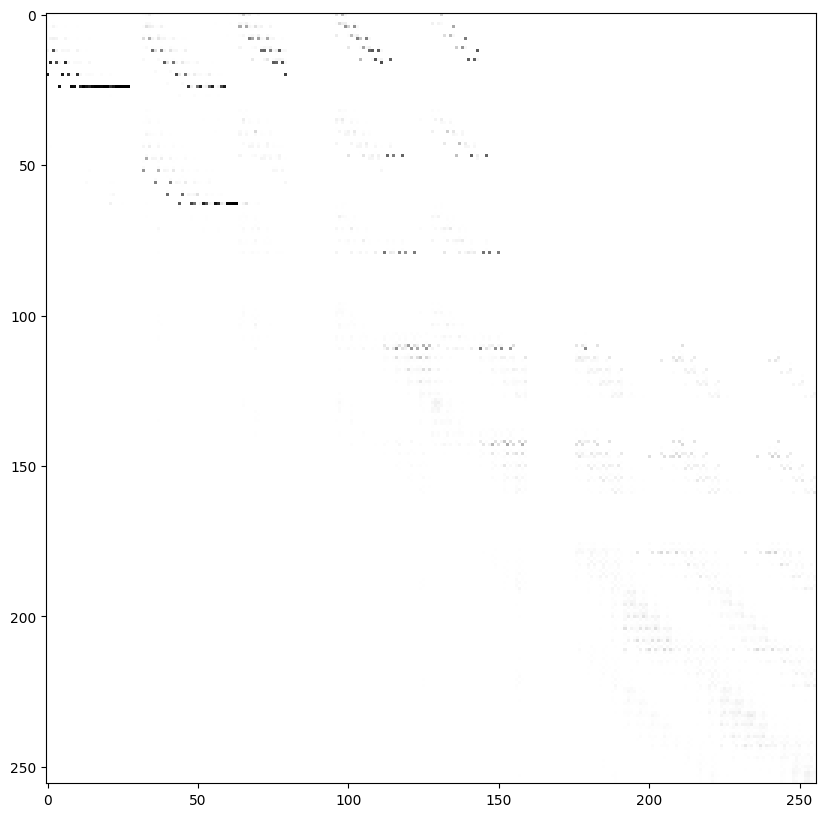

In [12]:
fig, ax = plt.subplots(figsize=(10,10))

ax.imshow(np.linalg.matrix_power(test.P_s_by_s.T, 5), cmap='Greys')

In [211]:
np.nonzero(test.P_s) 

(array([24, 25, 27]),)

In [62]:
test.run_policy_stats()

Step 0: Total probability = 1.0000


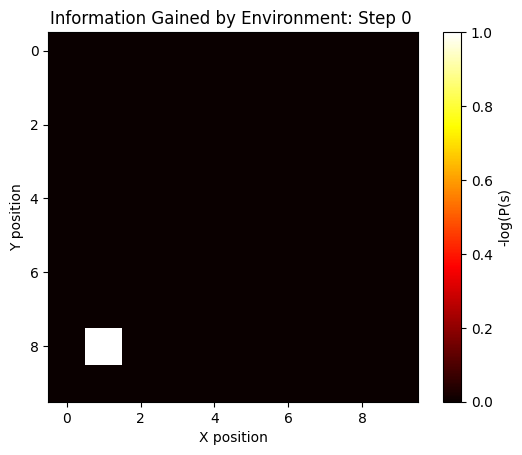

Step 1: Total probability = 1.0000


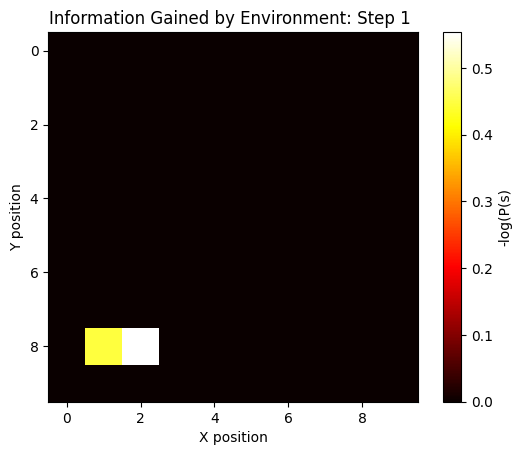

Step 2: Total probability = 1.0000


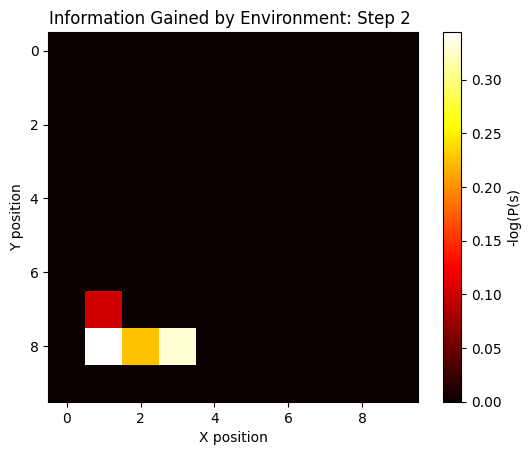

Step 3: Total probability = 1.0000


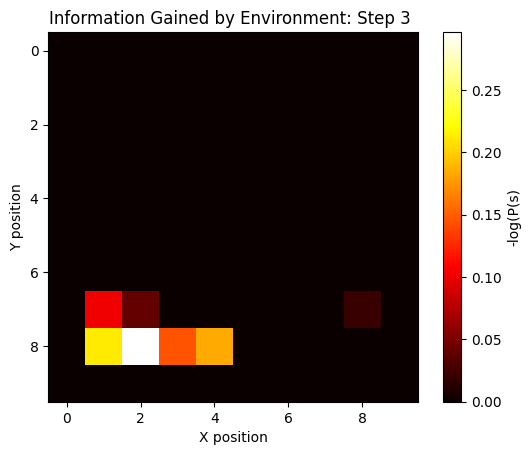

Step 4: Total probability = 1.0000


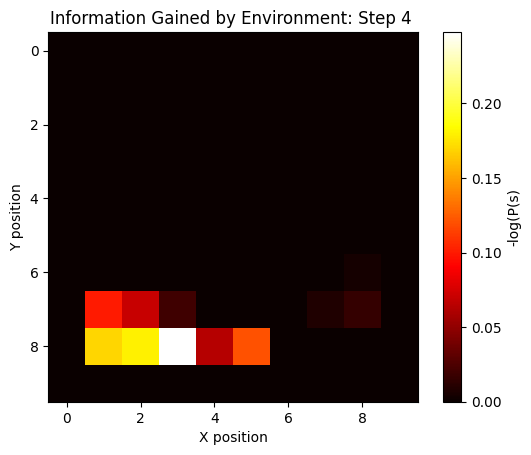

Step 5: Total probability = 1.0000


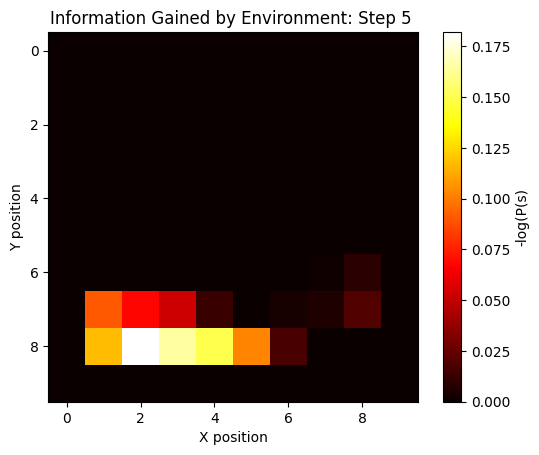

Step 6: Total probability = 1.0000


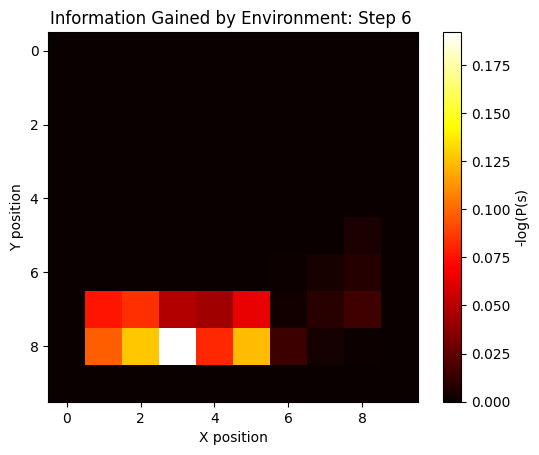

Step 7: Total probability = 1.0000


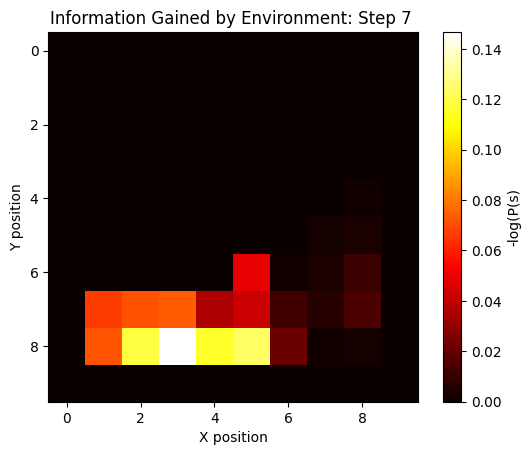

Step 8: Total probability = 1.0000


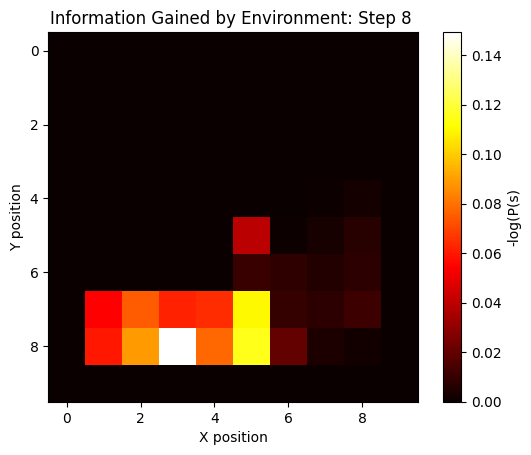

Step 9: Total probability = 1.0000


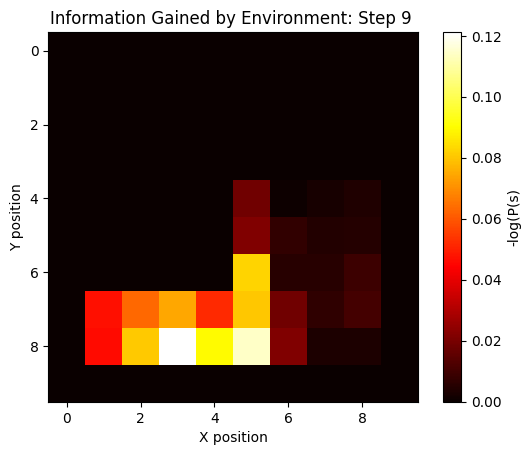

Step 10: Total probability = 1.0000


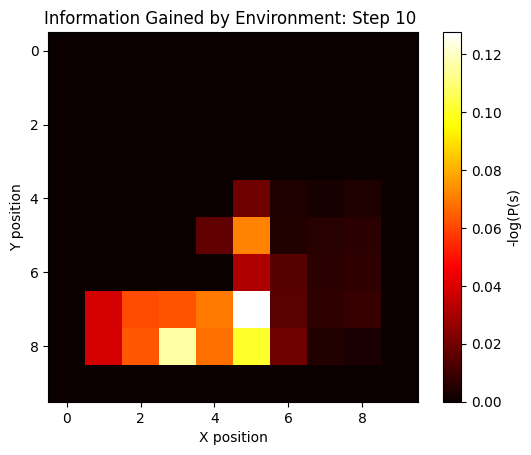

Step 11: Total probability = 1.0000


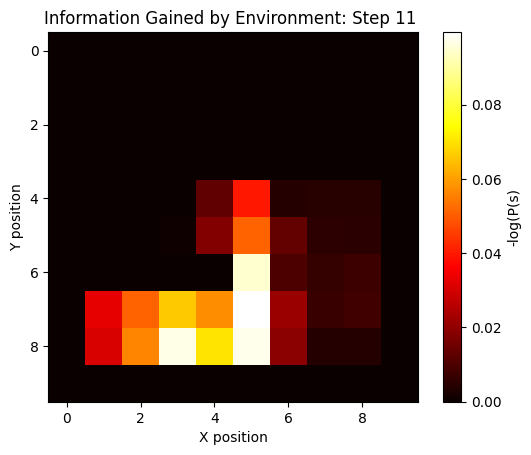

Step 12: Total probability = 1.0000


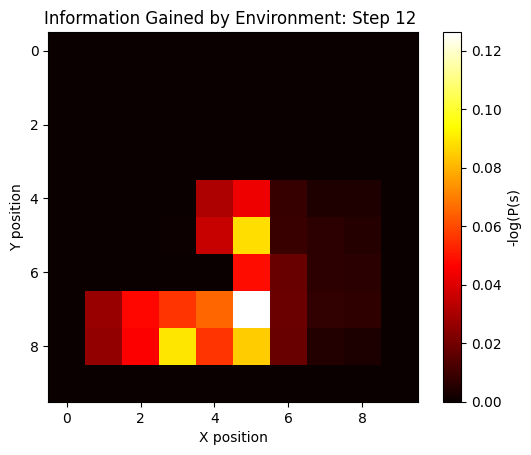

Step 13: Total probability = 1.0000


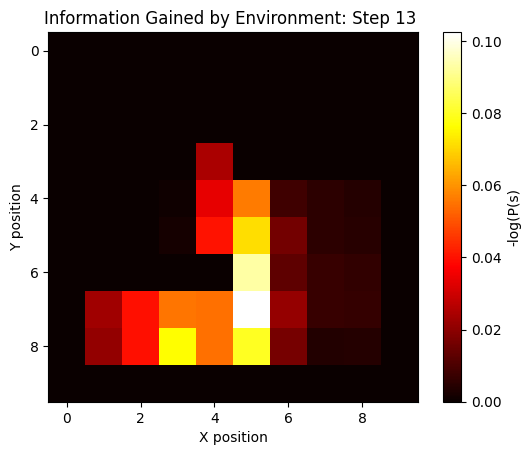

Step 14: Total probability = 1.0000


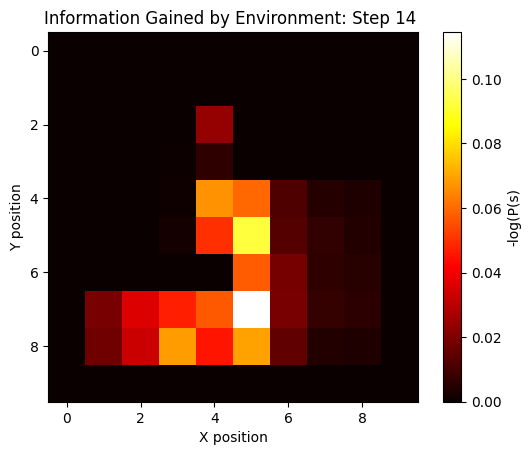

Step 15: Total probability = 1.0000


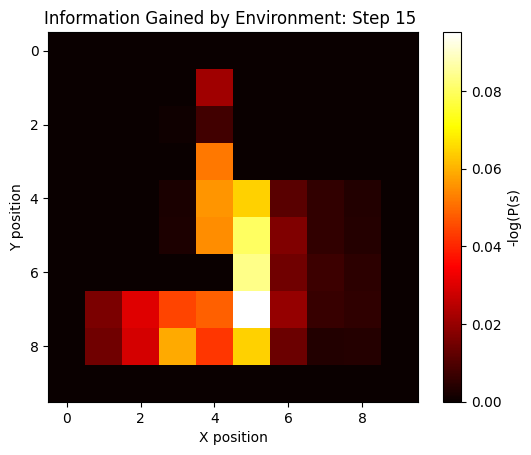

Step 16: Total probability = 1.0000


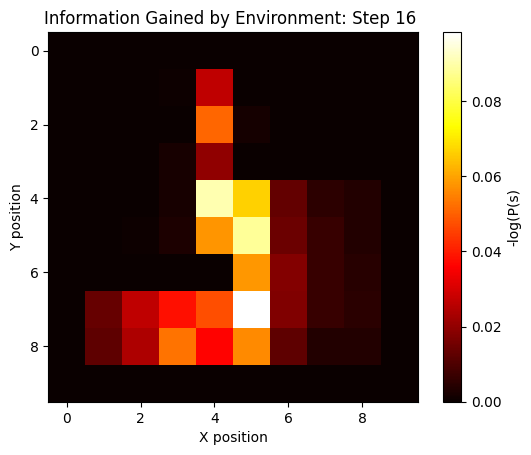

Step 17: Total probability = 1.0000


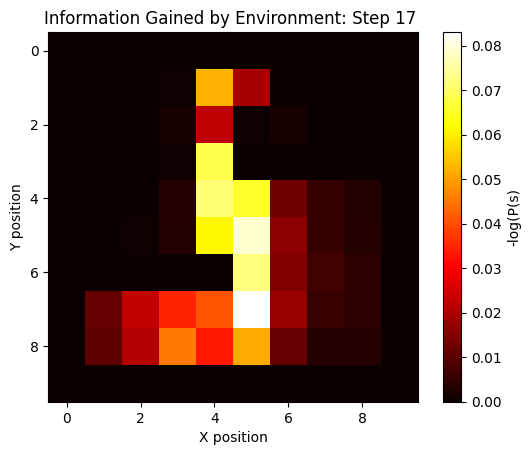

Step 18: Total probability = 1.0000


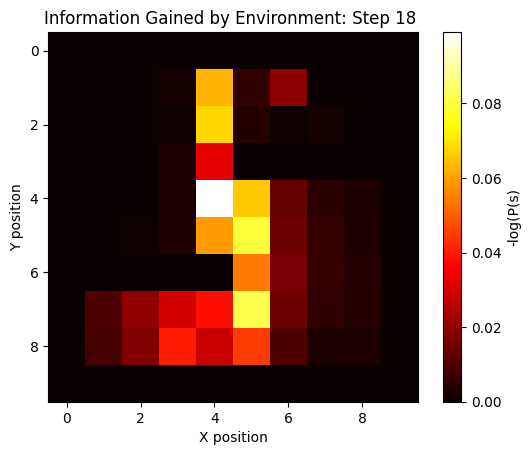

Step 19: Total probability = 1.0000


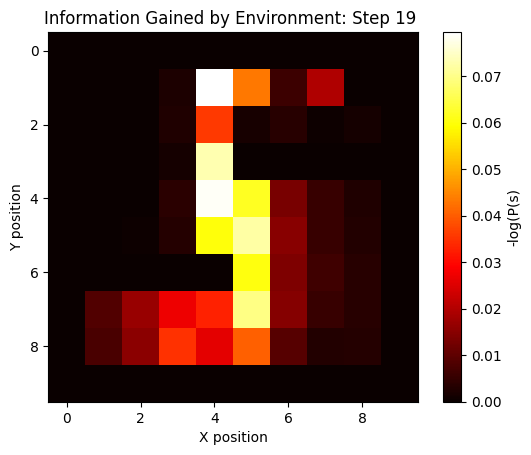

Step 20: Total probability = 1.0000


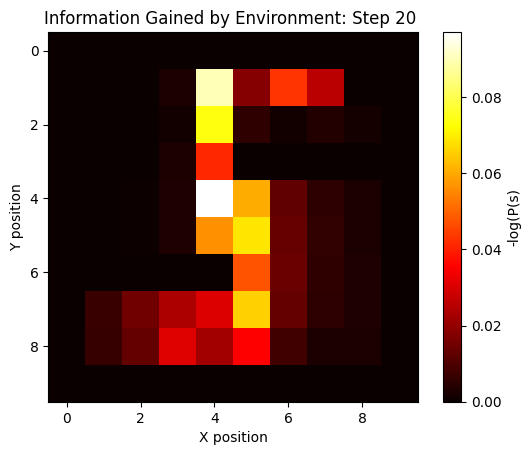

Step 21: Total probability = 1.0000


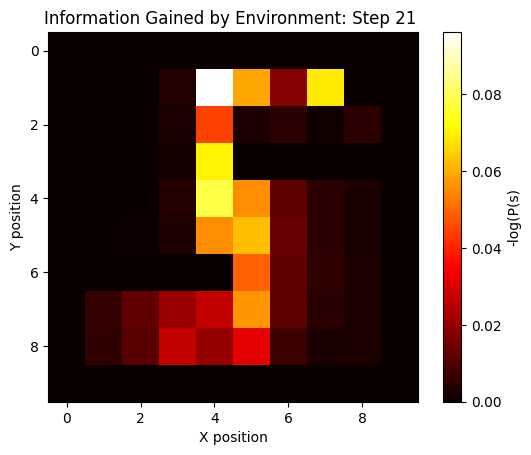

Step 22: Total probability = 1.0000


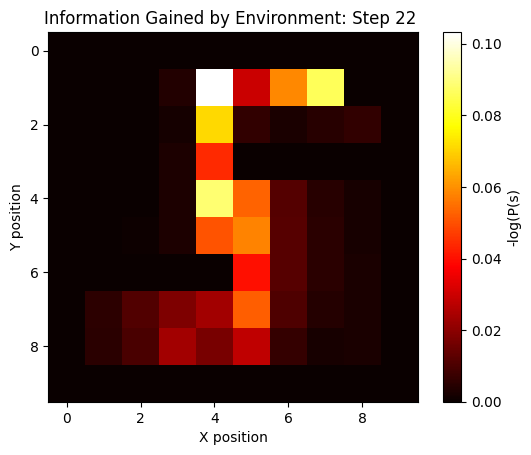

Step 23: Total probability = 1.0000


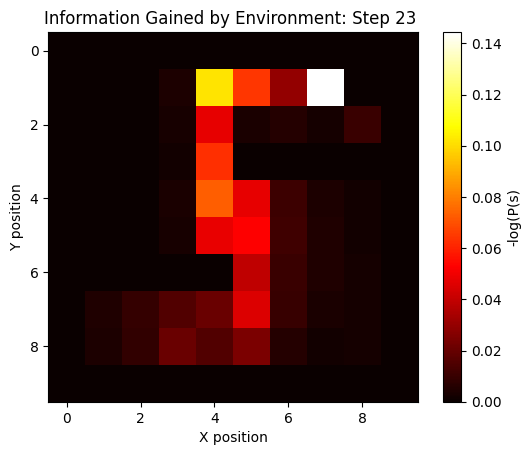

Step 24: Total probability = 1.0000


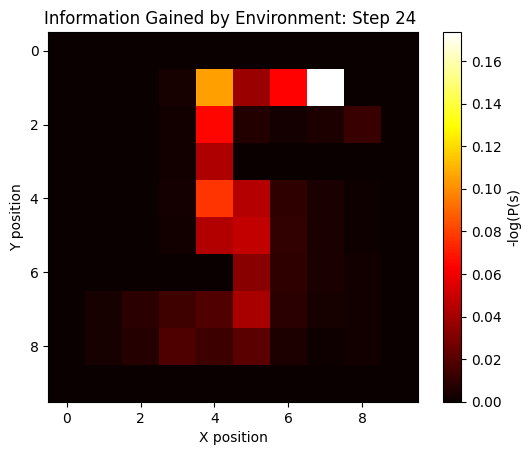

Step 25: Total probability = 1.0000


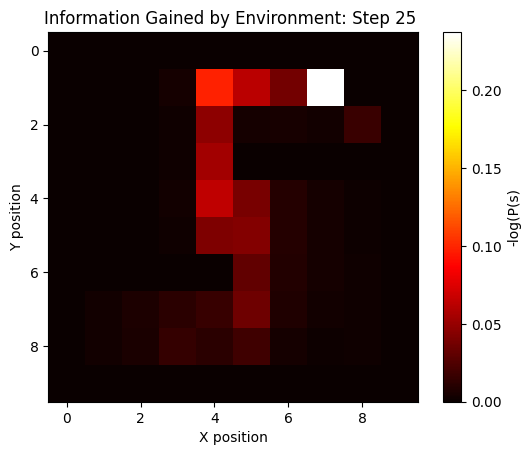

Step 26: Total probability = 1.0000


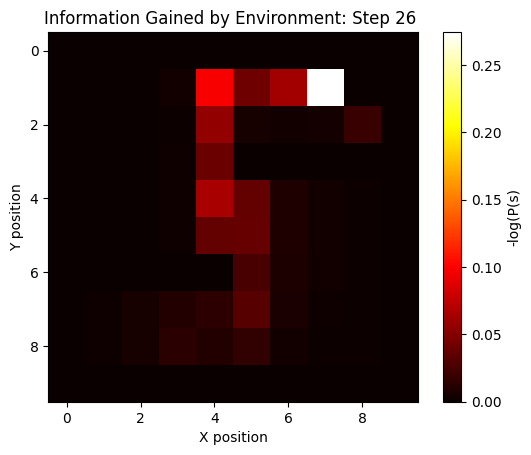

Step 27: Total probability = 1.0000


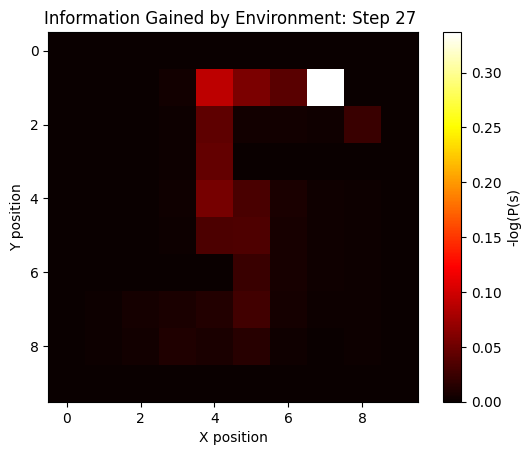

Step 28: Total probability = 1.0000


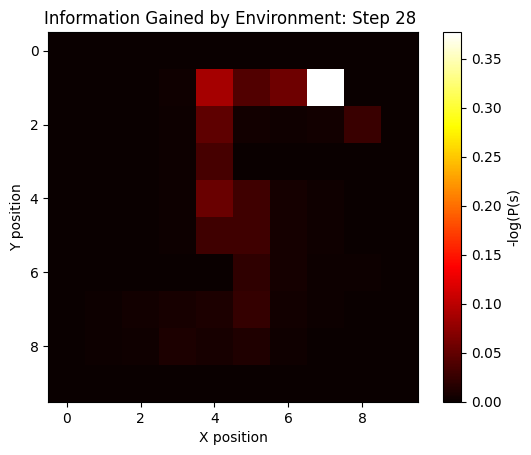

Step 29: Total probability = 1.0000


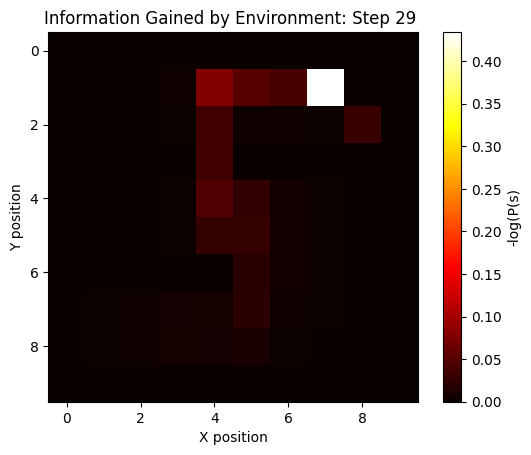

Step 30: Total probability = 1.0000


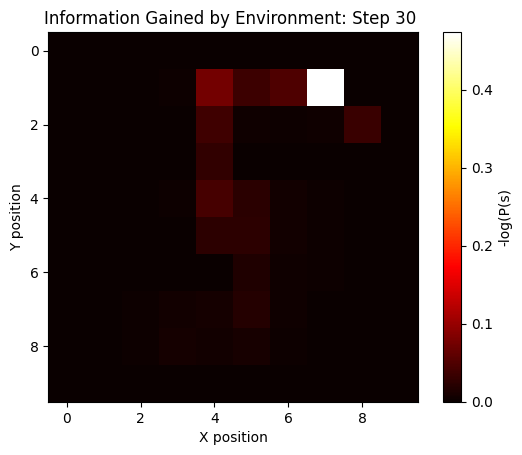

Step 31: Total probability = 1.0000


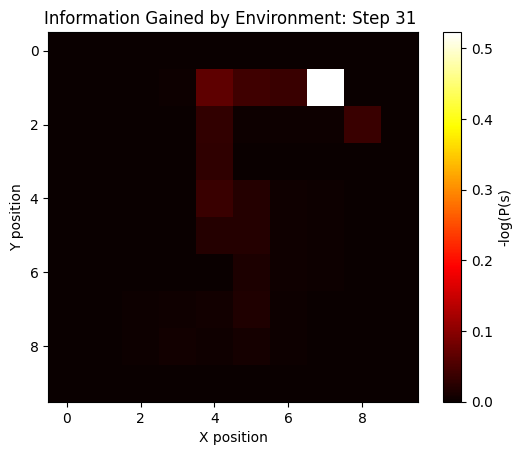

Step 32: Total probability = 1.0000


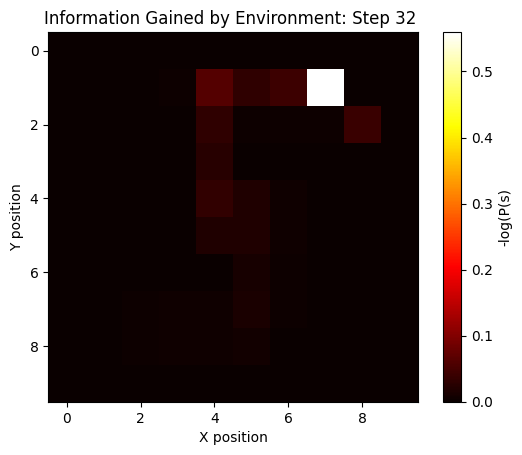

Step 33: Total probability = 1.0000


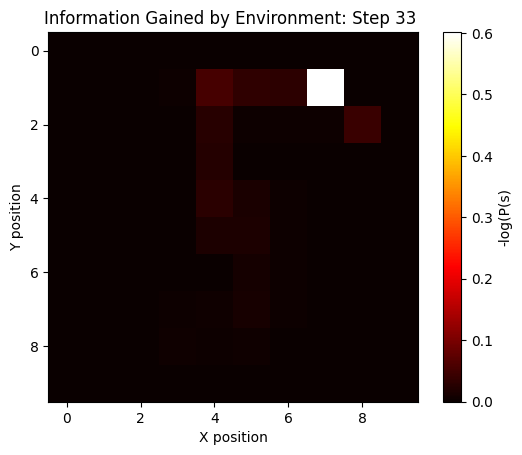

Step 34: Total probability = 1.0000


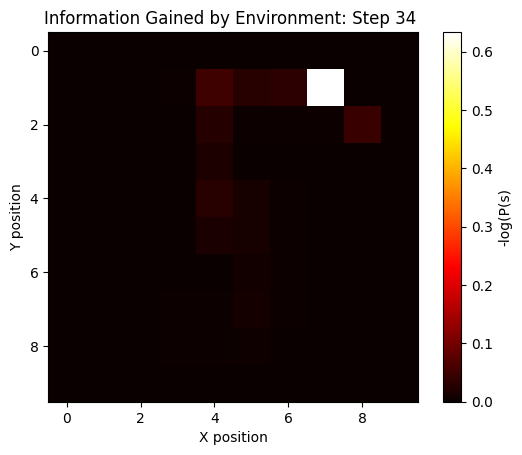

Step 35: Total probability = 1.0000


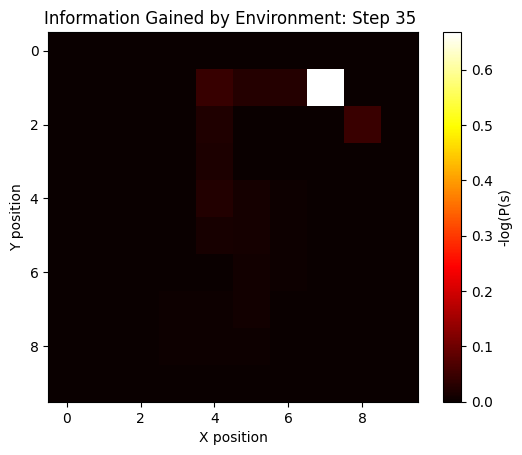

Step 36: Total probability = 1.0000


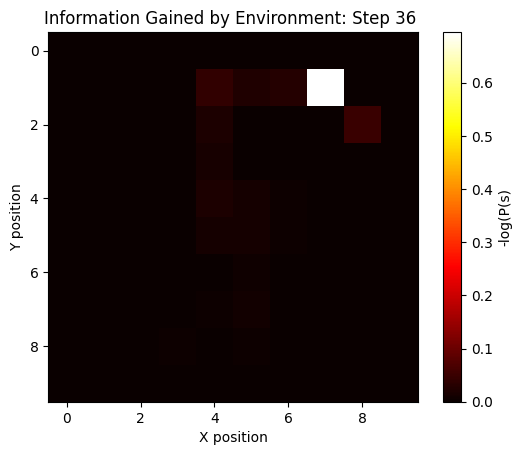

Step 37: Total probability = 1.0000


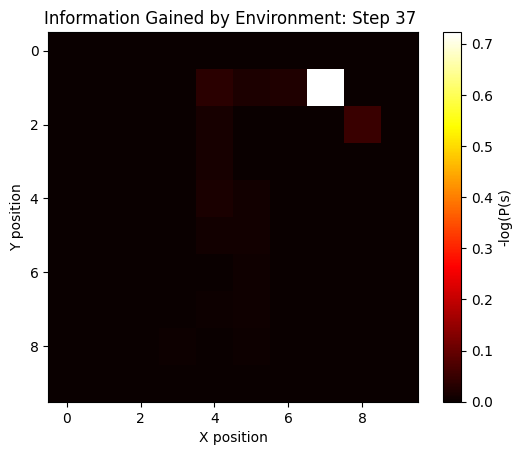

Step 38: Total probability = 1.0000


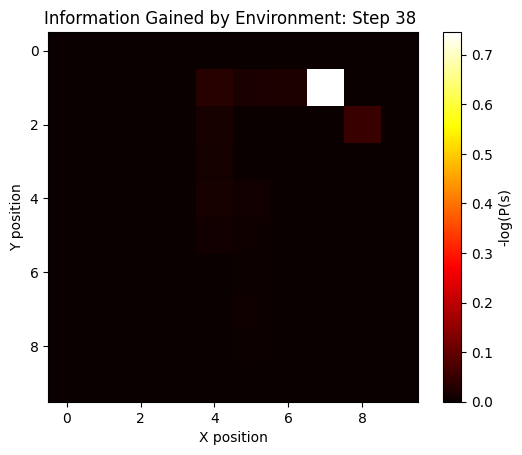

Step 39: Total probability = 1.0000


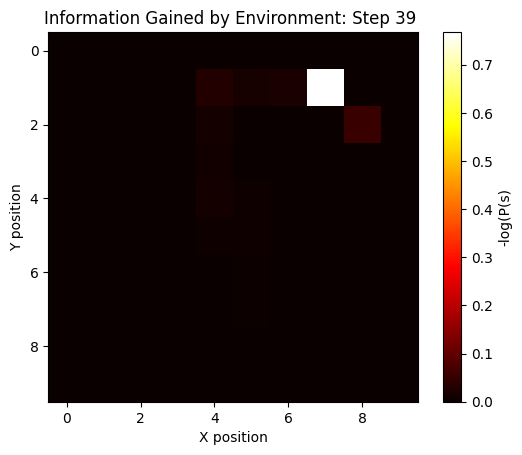

Step 40: Total probability = 1.0000


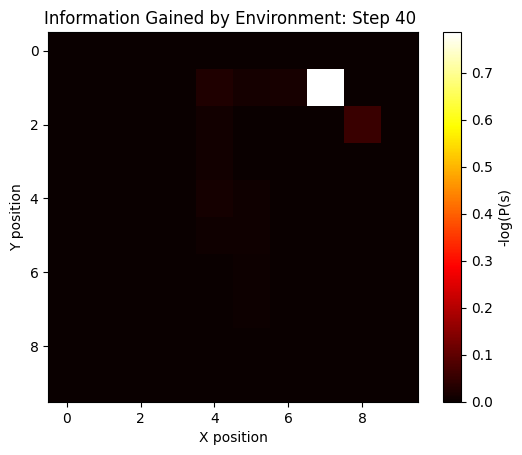

Step 41: Total probability = 1.0000


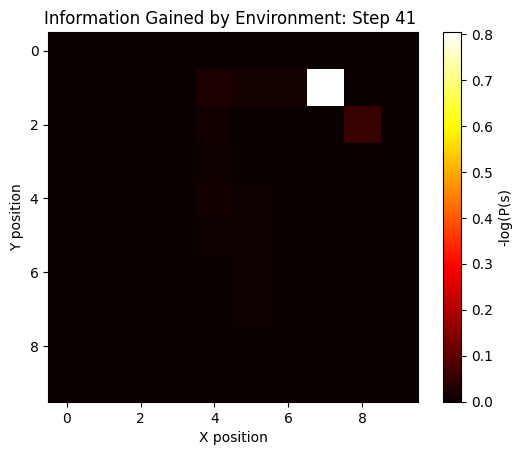

Step 42: Total probability = 1.0000


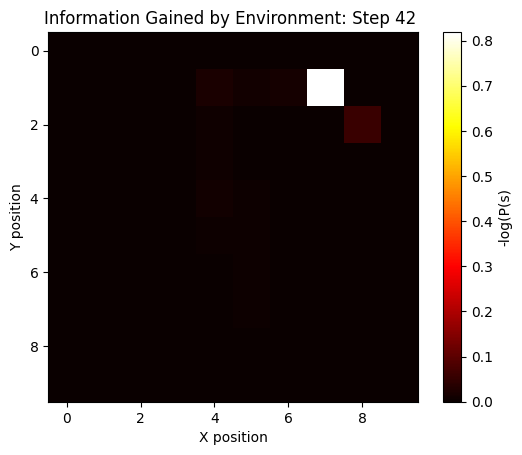

Step 43: Total probability = 1.0000


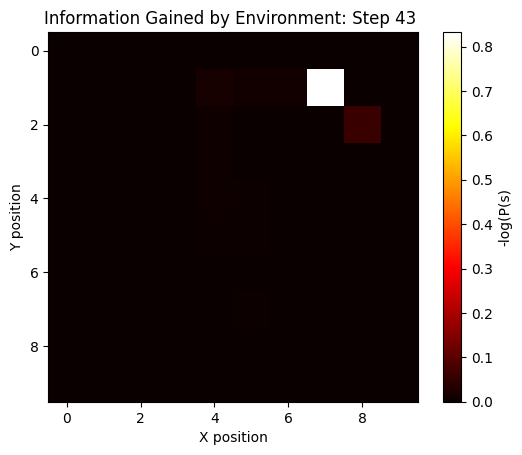

Step 44: Total probability = 1.0000


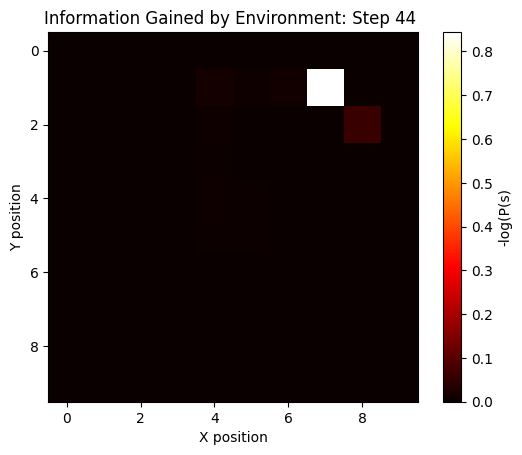

Step 45: Total probability = 1.0000


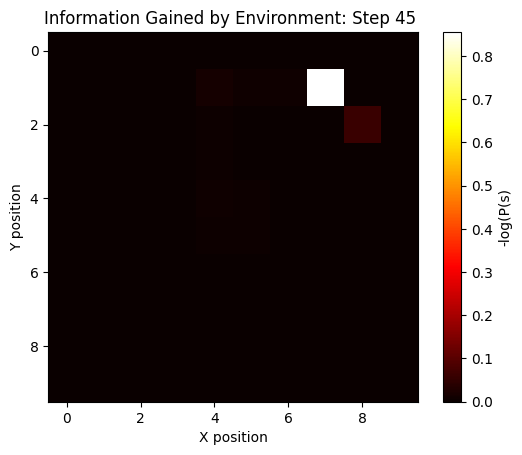

Step 46: Total probability = 1.0000


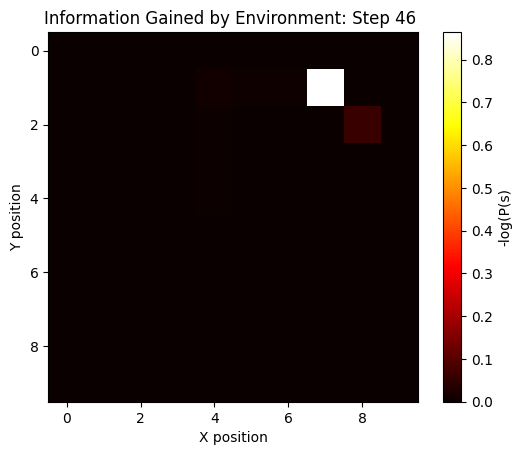

Step 47: Total probability = 1.0000


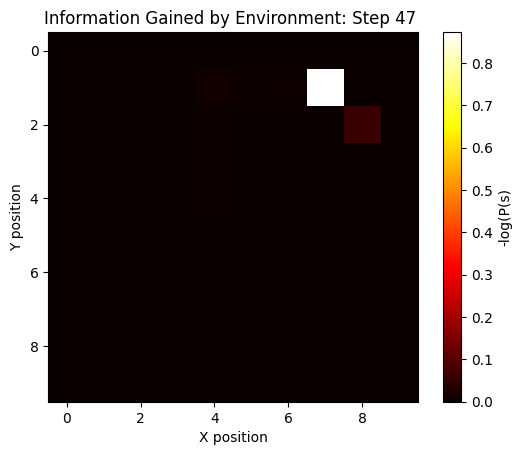

Step 48: Total probability = 1.0000


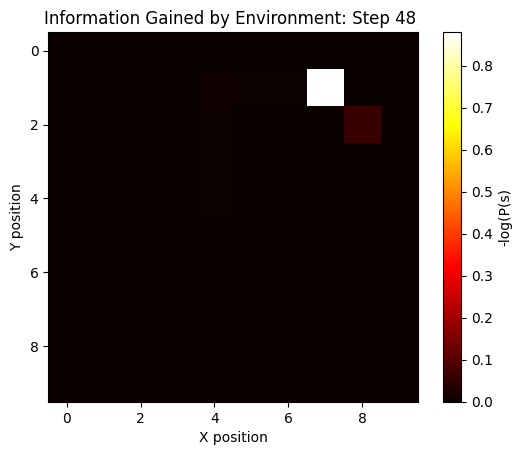

Step 49: Total probability = 1.0000


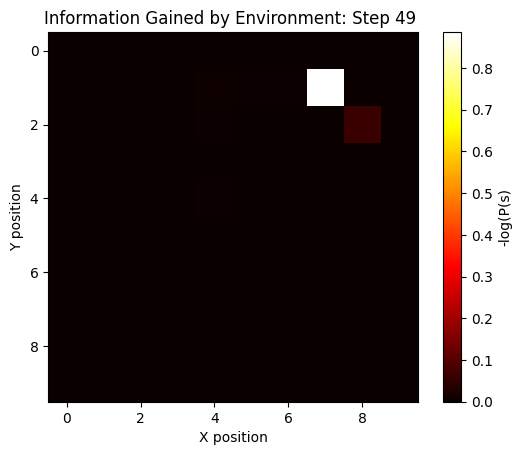

In [13]:
test.plot_all_heatmaps1()



In [172]:
test.save_all_heatmaps(folder_name="enivorment_decison_heatmaps")

Step 0: Total probability = 8807.3880
Step 1: Total probability = 8741.9489
Step 2: Total probability = 8614.9108
Step 3: Total probability = 8369.6133
Step 4: Total probability = 8013.8558
Step 5: Total probability = 7554.8276
Step 6: Total probability = 6999.1046
Step 7: Total probability = 6503.6775
Step 8: Total probability = 6164.5438
Step 9: Total probability = 5857.0889
Step 10: Total probability = 5560.3184
Step 11: Total probability = 5270.4290
Step 12: Total probability = 4993.0653
Step 13: Total probability = 4728.8570
Step 14: Total probability = 4402.9948
Step 15: Total probability = 4027.5127
Step 16: Total probability = 3693.4178
Step 17: Total probability = 3425.3778
Step 18: Total probability = 3208.7380
Step 19: Total probability = 3051.7771
Step 20: Total probability = 2969.4925
Step 21: Total probability = 2943.7877
Step 22: Total probability = 2941.0911
Step 23: Total probability = 2943.4977
Step 24: Total probability = 2950.6632
Step 25: Total probability = 2961.3

In [ ]:
def clear_folder(folder_name):
    files = glob.glob(os.path.join(folder_name, "*.png"))
    for f in files:
        os.remove(f)

In [124]:
clear_folder('heatmaps')

In [164]:
def create_video_from_images(image_folder, output_file, fps=2):
    """
    Create a video from a sequence of images saved in a folder.
    
    Parameters:
    - image_folder: Folder where the heatmap images are stored.
    - output_file: Path for the output video file (e.g., "simulation.mp4").
    - fps: Frames per second for the output video.
    """
    # Get a sorted list of image files from the folder
    image_pattern = os.path.join(image_folder, "heatmap_*.png")
    image_files = sorted(glob.glob(image_pattern))
    
    # Create a clip from the sequence of images
    clip = ImageSequenceClip(image_files, fps=fps)
    
    # Write the video file
    clip.write_videofile(output_file, codec='libx264', audio_codec="aac" )

In [174]:
# Usage example:
create_video_from_images("enivorment_decison_heatmaps", "env_beta5.mp4", fps=4)

MoviePy - Building video env_beta5.mp4.
MoviePy - Writing video env_beta5.mp4



MoviePy - Done !
MoviePy - video ready env_beta5.mp4


In [65]:
beta_explore = probabilisticQlearning(env)

In [66]:
beta_dictionary = beta_explore.run_mulitple_betas(runs_per_beta = 10)

In [ ]:
beta_dictionary

In [227]:
#plot each value in the dictionary
x = list(beta_dictionary.keys())    
y = list(beta_dictionary.values())
y_neg = [-i for i in y]
plt.figure(figsize=(12, 6))
plt.plot((x), y_neg, marker='o')
plt.xlabel('Beta Value')
plt.ylabel('Average Steps Taken')
plt.title('Average Steps Taken vs. Beta Value')
# plt.xticks(list(beta_dictionary.keys()), rotation=45)
# plt.yticks(list(beta_dictionary.values()))
plt.show()

NameError: name 'beta_dictionary' is not defined